In [94]:
# Import Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [95]:
#Import data

df = pd.read_csv("Case Study - Transaction.csv",sep=";")
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [96]:
#Group by Date and aggregate TrabsactionID count, Qty sum, and TotalAmount sum

df_agg = df.groupby('CustomerID').agg({"TransactionID":"count",
                                      "Qty":"sum",
                                      "TotalAmount":"sum"}).reset_index()
df_agg.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


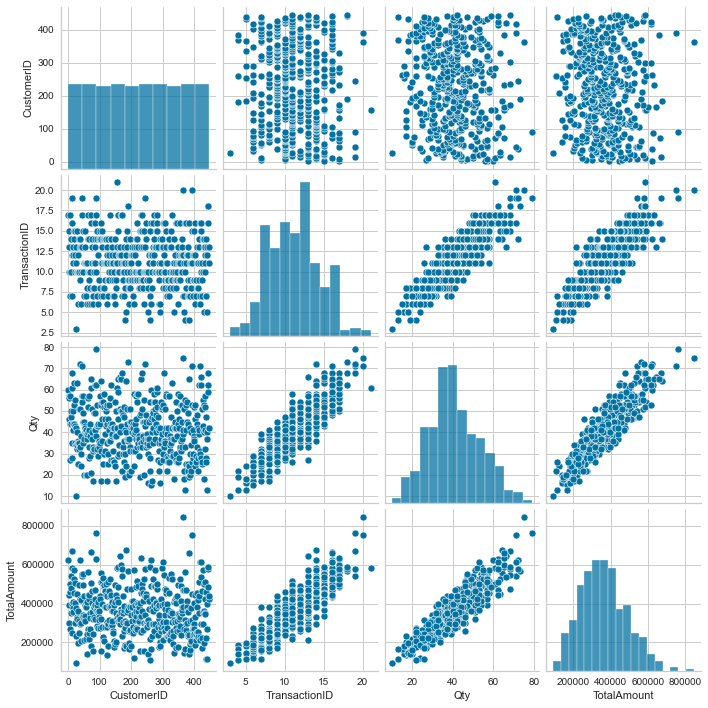

In [97]:
# Pair plot using seaborn to see data relationship

sns.pairplot(df_agg)

Text(0, 0.5, 'Total Amount')

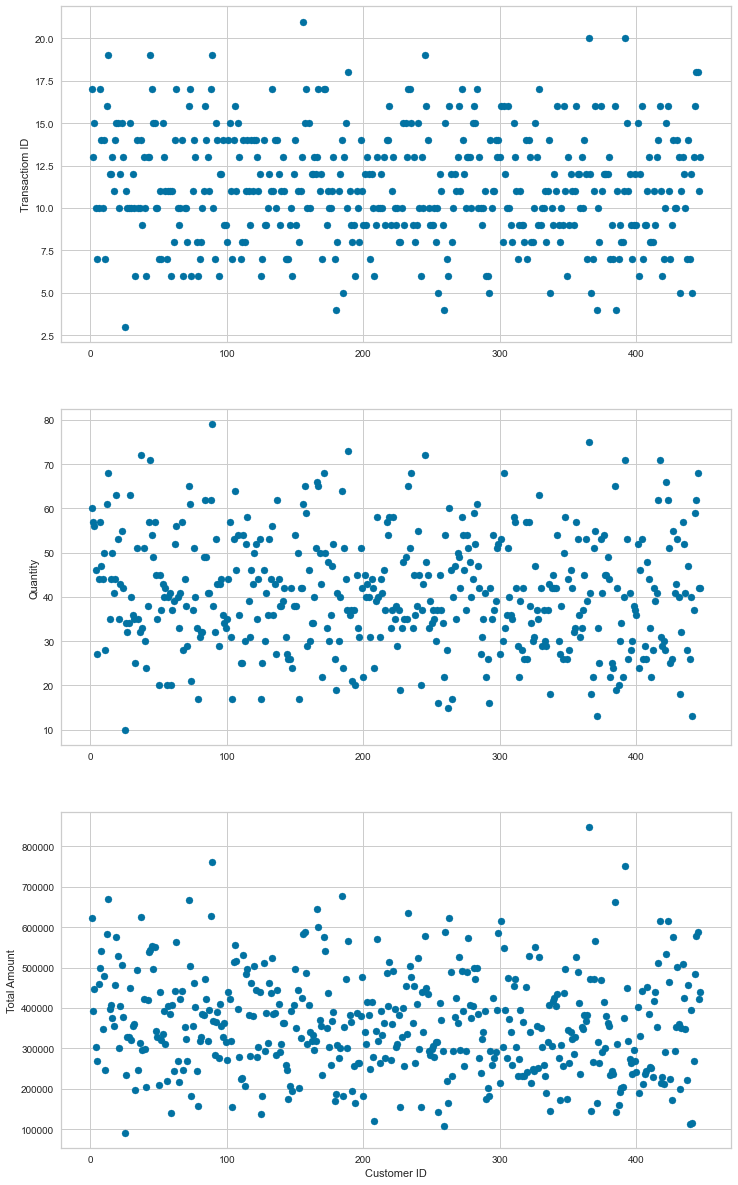

In [98]:
# Plot each data with CustomerID

fig, axs = plt.subplots(3, figsize=(12,21))
axs[0].scatter(df_agg["CustomerID"],df_agg["TransactionID"])
axs[0].set_ylabel("Transactiom ID")
axs[1].scatter(df_agg["CustomerID"],df_agg["Qty"])
axs[1].set_ylabel("Quantity")
axs[2].scatter(df_agg["CustomerID"],df_agg["TotalAmount"])
axs[2].set_xlabel("Customer ID")
axs[2].set_ylabel("Total Amount")

Text(0.5, 1.0, 'Total Amount')

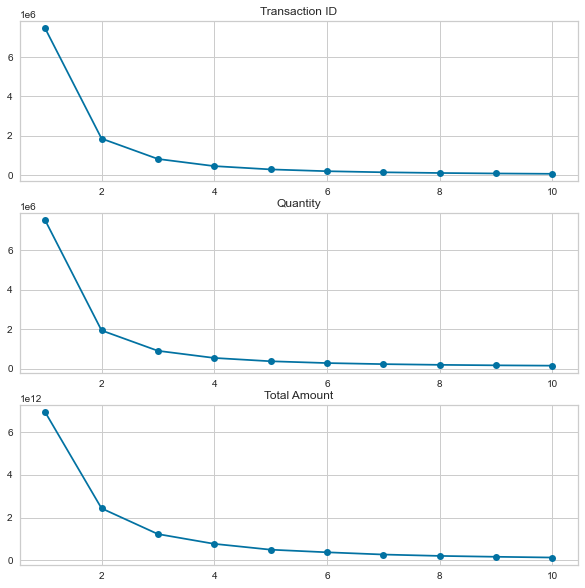

In [99]:
# Elbow method to find the best number of cluster

d1 = df_agg[["CustomerID","TransactionID"]]
d2 = df_agg[["CustomerID","Qty"]]
d3 = df_agg[["CustomerID","TotalAmount"]]

fig, axs = plt.subplots(3, figsize=(10,10))

x = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d1)
    x.append(kmeans.inertia_)
axs[0].plot(range(1,11), x, marker="o")
axs[0].set_title("Transaction ID")

x2 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d2)
    x2.append(kmeans.inertia_)
axs[1].plot(range(1,11), x2, marker="o")
axs[1].set_title("Quantity")

x3 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d3)
    x3.append(kmeans.inertia_)
axs[2].plot(range(1,11), x3, marker="o")
axs[2].set_title("Total Amount")

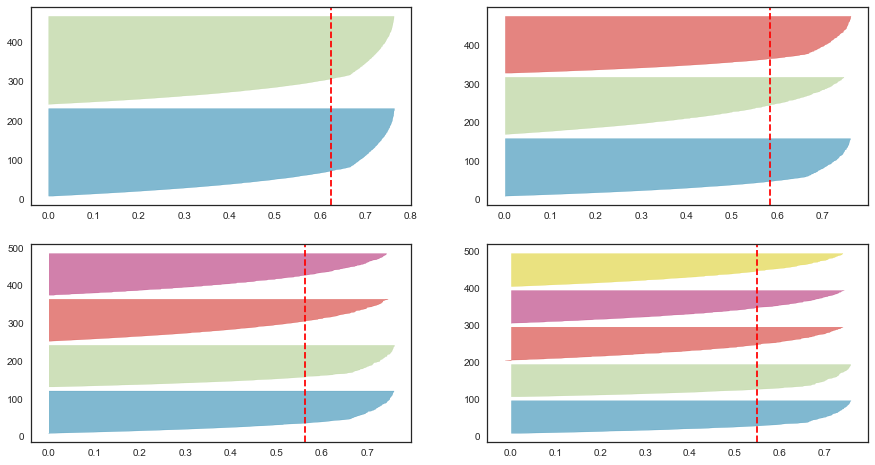

In [108]:
# Silhouete score to further find the best number of cluster

from yellowbrick.cluster import SilhouetteVisualizer

# Silhouete score for CustomerID and TransactionID
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range (2,6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(d1)

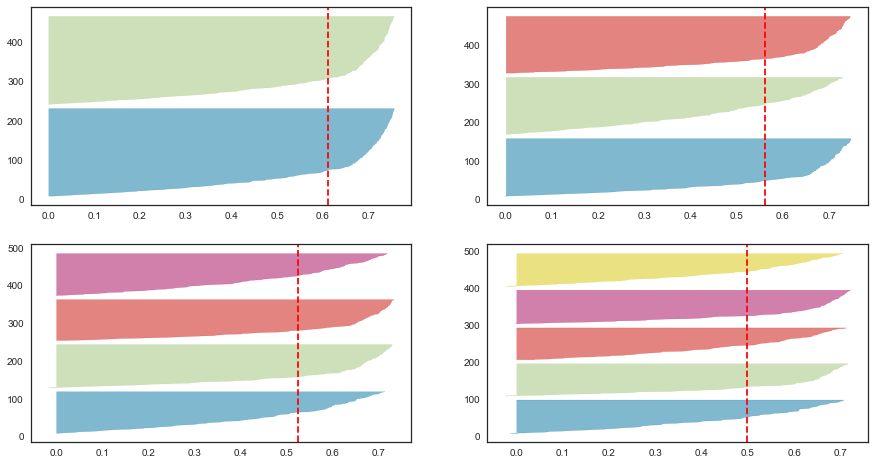

In [109]:
# Silhouete score for CustomerID and Qty
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range (2,6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(d2)

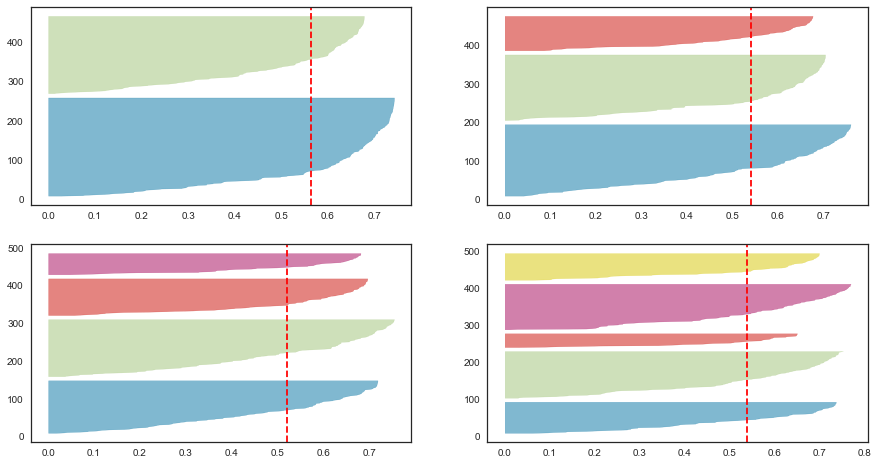

In [110]:
# Silhouete score for CustomerID and TotalAmount

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range (2,6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(d3)

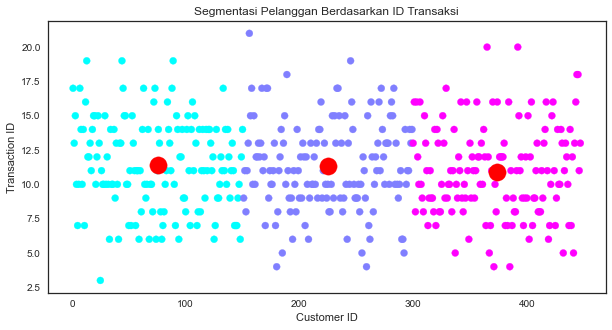

In [101]:
# Plot clustering using KMeans

# KMeans clustering for CustomerID and TransactionID
model1 = KMeans(n_clusters=3, init="k-means++", n_init=10, max_iter=300, tol=0.0001, random_state=42)
model1.fit(d1)
labels1 = model1.labels_
centroids1 = model1.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_agg["CustomerID"], y=df_agg["TransactionID"], c=labels1, cmap="cool")
plt.scatter(x=centroids1[:,0], y=centroids1[:,1], s=300, c="red")
plt.title("Segmentasi Pelanggan Berdasarkan ID Transaksi")
plt.xlabel("Customer ID")
plt.ylabel("Transaction ID")
plt.show()

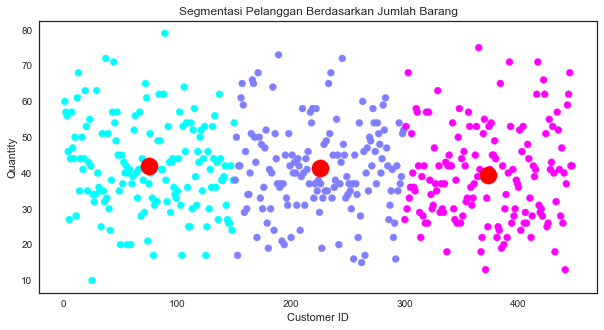

In [113]:
# KMeans clustering for CustomerID and Qty
model2 = KMeans(n_clusters=3, init="k-means++", n_init=10, max_iter=300, tol=0.0001, random_state=42)
model2.fit(d2)
labels2 = model2.labels_
centroids2 = model2.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_agg["CustomerID"], y=df_agg["Qty"], c=labels2, cmap="cool")
plt.scatter(x=centroids2[:,0], y=centroids2[:,1], s=300, c="red")
plt.title("Segmentasi Pelanggan Berdasarkan Jumlah Barang")
plt.xlabel("Customer ID")
plt.ylabel("Quantity")
plt.show()

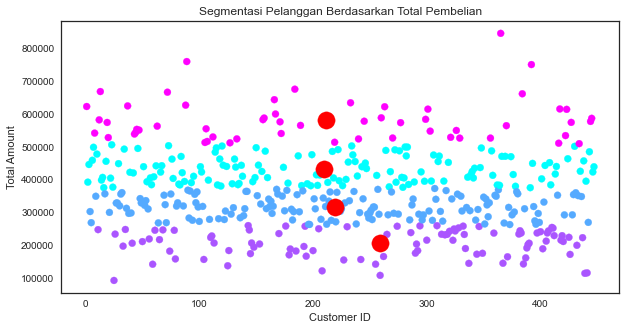

In [112]:
# KMeans clustering for CustomerID and TotalAmount
model3 = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300, tol=0.0001, random_state=42)
model3.fit(d3)
labels3 = model3.labels_
centroids3 = model3.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_agg["CustomerID"], y=df_agg["TotalAmount"], c=labels3, cmap="cool")
plt.scatter(x=centroids3[:,0], y=centroids3[:,1], s=300, c="red")
plt.title("Segmentasi Pelanggan Berdasarkan Total Pembelian")
plt.xlabel("Customer ID")
plt.ylabel("Total Amount")
plt.show()